# ***Desi Human Glioma Dataset Preprocessing***

This notebook shows the preprocessing of the Desi Human Glioma Dataset.

### ***Import packages***

Before we begin, let's import all the necessary packages for this notebook.
First we add the directory which has our python files:

In [1]:
import sys
sys.path.insert(0, "/sise/assafzar-group/assafzar/Leor")

Next we import all the necessary packages for this notebook:

In [12]:
%matplotlib inline
from os import listdir
from os.path import dirname, realpath, join
from pathlib import Path
from tqdm.notebook import tqdm
from pyimzml.ImzMLParser import ImzMLParser
from pyimzml.ImzMLWriter import ImzMLWriter
from matplotlib import pyplot as plt
from NanoBiopsy.normalization.normalizer_factory import NormalizerFactory
from NanoBiopsy.binning.binning_factory import BinningFactory

### ***Constants definitions***

Next, let's define some constant variables for this notebook:

In [3]:
# Define folder that contains the dhg dataset
DHG_IN_PATH = "/sise/assafzar-group/assafzar/Leor/DHG/Original"
# Define folder to save preprocess output
DHG_OUT_PATH = "/sise/assafzar-group/assafzar/Leor/DHG/Normalized"
# Define what type of normalization we will use
NORM_TYPE = "TIC"
# Define what type of binning we will use
BIN_TYPE = "Equal_Width"
# Define mass range start value
MZ_START = 50
# Define mass range end value
MZ_END = 1200
# # Define mass resolution of the data
MASS_RESOLUTION = 0.025

### ***Creating DHG_OUT_PATH folder***

Next, lets create the DHG_OUT_PATH folder:

In [4]:
# Create DHG_OUT_PATH folder if doesn't exist
Path(DHG_OUT_PATH).mkdir(parents=True, exist_ok=True)

### ***Getting all msi names preprocess pipeline***

Next, lets get all the msi names from DHG_IN_PATH:

In [5]:
# Get all msi names
msi_names = [file for file in listdir(DHG_IN_PATH) if file.endswith(".imzML")]

### ***Creating preprocess variables for each preprocess step***

Next, lets create a variable for for each preprocess step:

In [6]:
# Get normalizer object
normalizer = NormalizerFactory().get_normalizer(NORM_TYPE)
# Get binning object
binning = BinningFactory().get_binning(BIN_TYPE, MZ_START, MZ_END, MASS_RESOLUTION / 2)

### ***Visualizing preprocess on single spectra***

Next, lets visualize the preprocess pipeline for a single spectra:

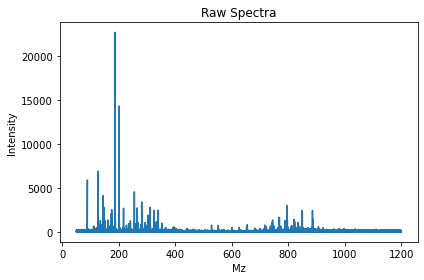

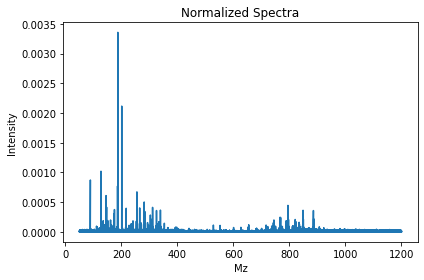

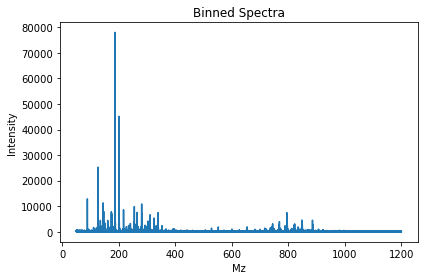

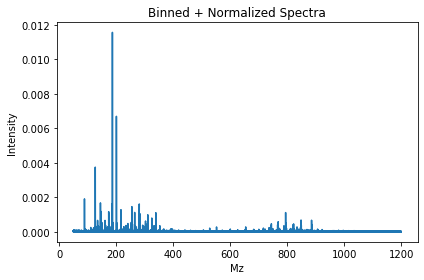

In [18]:
with ImzMLParser(join(DHG_IN_PATH, msi_names[0])) as reader:
  # get single spectra
  original_mzs, original_intensities = reader.getspectrum(2999)

  # normalize spectrum
  normalized_mzs, normalized_intensities = normalizer.normalize(
      (original_mzs, original_intensities))

  #  bin spectrum
  binned_mzs, binned_intensities = binning.bin(
      (original_mzs, original_intensities))

  # normalize and bin spectrum
  binned_normalized_mzs, binned_normalized_intensities = binning.bin((normalized_mzs, normalized_intensities))

  # Plot raw spectra
  plt.plot(original_mzs, original_intensities)
  plt.xlabel('Mz')
  plt.ylabel('Intensity')
  plt.title('Raw Spectra')
  plt.tight_layout()
  plt.show()

  # Plot normalized spectra
  plt.plot(normalized_mzs, normalized_intensities)
  plt.xlabel('Mz')
  plt.ylabel('Intensity')
  plt.title('Normalized Spectra')
  plt.tight_layout()
  plt.show()

  # Plot binned spectra
  plt.plot(binned_mzs, binned_intensities)
  plt.xlabel('Mz')
  plt.ylabel('Intensity')
  plt.title('Binned Spectra')
  plt.tight_layout()
  plt.show()

  # Plot binned + normalized spectra
  plt.plot(binned_normalized_mzs, binned_normalized_intensities)
  plt.xlabel('Mz')
  plt.ylabel('Intensity')
  plt.title('Binned + Normalized Spectra')
  plt.tight_layout()
  plt.show()

### ***Creating preprocess pipeline***

Next, lets create the preprocess pipeline for each spectra in the image:

In [4]:
pre_process_pipe = (
  lambda mzs, intensities: (
    binning.bin(
      normalizer.normalize((mzs, intensities))
    )
  )
)

### ***Applying preprocess pipeline on each msi***

Next, lets apply the preprocess pipeline for each spectra in each msi in dhg:

In [5]:
# Loop over each msi name
for msi_name in tqdm(msi_names, desc="Image Loop"):
  # Create a new preprocessed msi. because we apply binning 
  # we can use mode="continuous"
  with ImzMLWriter(join(DHG_OUT_PATH, msi_name), mode="continuous") as writer:
    # Parse the msi file
    with ImzMLParser(join(DHG_IN_PATH, msi_name)) as reader:
      # Loop over each spectra in msi
      for idx, (x, y, z) in tqdm(enumerate(reader.coordinates),
                                 total=len(reader.coordinates),
                                 desc="Spectra Loop"):
        # Read spectra
        mzs, intensities = reader.getspectrum(idx)
        # Apply preprocessing pipe
        mzs, intensities = pre_process_pipe(mzs, intensities)
        # Write processed spectra to new preprocessed msi
        writer.addSpectrum(mzs, intensities, (x, y, z))

Image Loop:   0%|          | 0/1 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/7482 [00:00<?, ?it/s]